# stacking ensemble(스태킹 앙상블)

stacking은 개별적인 여러 알고리즘을 서로 결합하는 형태라서 일종의 ensemble이라고도 불립니다.  
하지만, 조금 차이점이 있습니다.


일단 기존 방법의 훈련은 아래 그림과 같습니다.

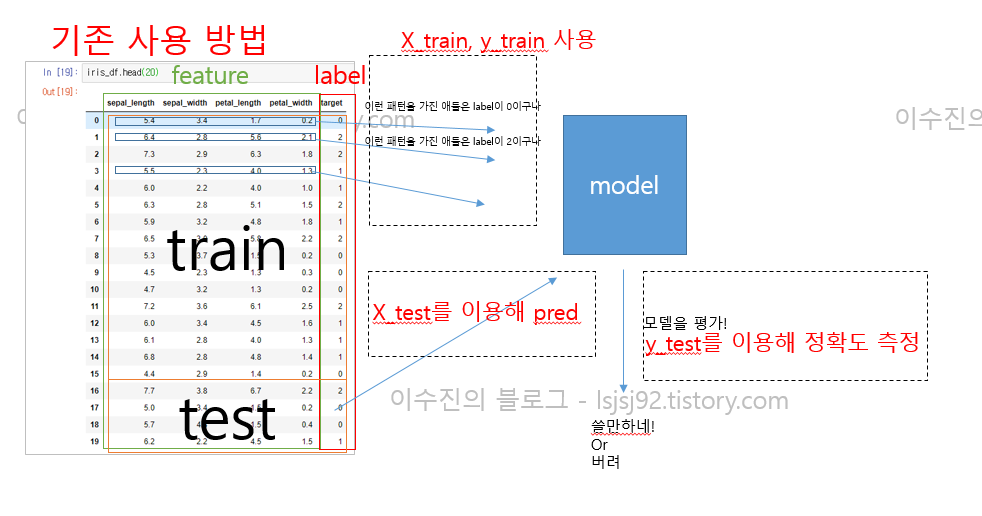


바로 **개별 모델이 예측한 데이터를 기반으로 다시 학습**한다는 것입니다.  

즉, 예시가 100% 맞지는 않지만 개념적으로 아래와 같습니다.  

- 원본 데이터의 train, test가 존재
- 원본 training 데이터를 4개의 머신러닝 모델이 학습
- 각 모델마다 x_test를 넣어서 예측 진행 후 predict를 뽑아냄 (4개의 predict)
- 4개의 predict를 다시 학습 데이터로 사용
- 최종 model을 하나 선정해서 해당 모델을 이용해 4개의 predict된 데이터를 학습


그래서 stacking을 할 때는 2가지 형태의 모델이 필요합니다.  
1. 개별 모델들 (복수)
2. 최종 모델 (하나)

보통 stacking은 일반적으로 잘 사용하지는 않습니다. 그러나 캐글(kaggle)같은 대회에서 조금이라도 성능 수치를 올리고자 할 때 사용하는 방법입니다.



단순하게 생각하면 stacking은 아래와 같습니다.

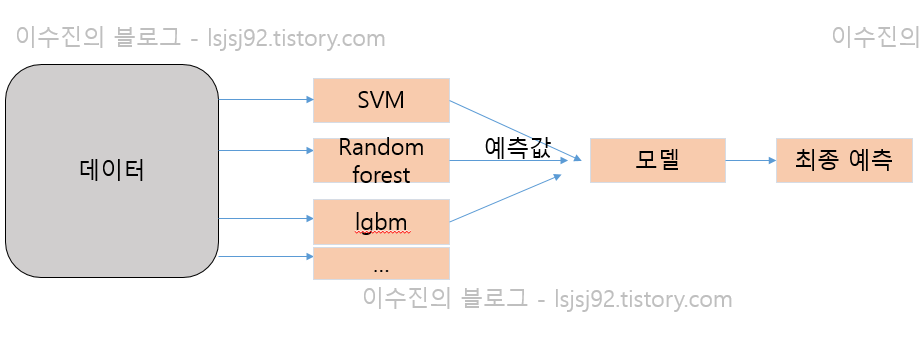


이를 조금 더 자세하게 살펴보면 아래 그림과 같습니다.

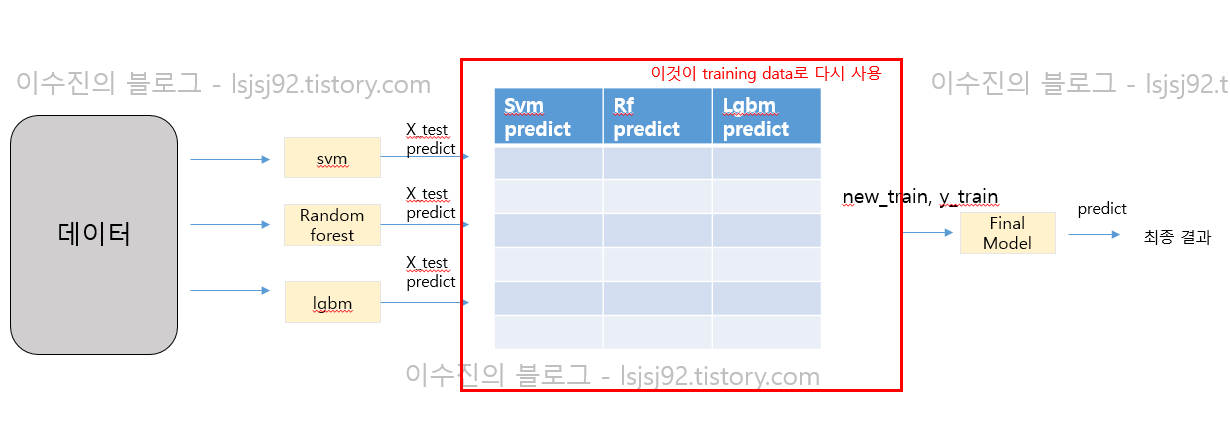


스태킹은 기본적인 모델과 cv 기반 모델이 있습니다.

이 기본적인 모델을 이해하지 않고서는 cv 기반 모델을 이해하기란 쉽지 않습니다.


기본적인 모델을 먼저 이해해보죠!


# 기본적인 stacking

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance as lgb_importance
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = load_breast_cancer()

X_data = data.data
y_data = data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 0)

In [3]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(455, 30) (114, 30)
(455,) (114,)


이제 stacking에 사용될 개별 모델과 최종 모델을 생성합니다.  

최종 모델은 lightgbm를 사용할 예정입니다. 그리고 개별 모델은 random forest, logistic regression, svc로 하겠습니다.

In [4]:
#개별 모델들 
svm = SVC(random_state=0)
rf = RandomForestClassifier(n_estimators = 100, random_state=0)
lr = LogisticRegression()


#최종 모델
lgbm = LGBMClassifier()

In [5]:
svm.fit(X_train, y_train)
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
svm_pred = svm.predict(X_test)
rf_pred = rf.predict(X_test)
lr_pred = lr.predict(X_test)

print("svm : {0:.4f}. rf : {1:.4f}, lr : {2:.4f}".format(accuracy_score(y_test, svm_pred),accuracy_score(y_test, rf_pred), accuracy_score(y_test, lr_pred)))

svm : 0.5877. rf : 0.9649, lr : 0.9561


이제 이 예측 데이터를 하나의 새로운 데이터로 만든다

In [7]:
new_data = np.array([svm_pred, rf_pred, lr_pred])
new_data.shape

(3, 114)

근데 이게 지금 행이 3개고(모델이 3개니) 열이 114개로 되어 있다.   
이를 전치해준다.

In [8]:
new_data = np.transpose(new_data)
new_data.shape

(114, 3)

그럼 이제 114개의 데이터(Test 데이터로 예측 했기 때문에)를 가지고 3개의 모델을 가진 새로운 데이터가 생성

In [9]:
new_data[:10]

array([[1, 0, 0],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

이제 이 데이터를 학습용으로 사용해서 y_test와 함께 훈련해준다.

In [10]:
lgbm.fit(new_data, y_test)
lgbm_pred = lgbm.predict(new_data)
print("정확도 : {0:.4f}".format(accuracy_score(y_test, lgbm_pred)))

정확도 : 0.9825


이렇게 하는 방법이 stacking의 기본적인 방법입니다!

굉장히 혼란스럽고 햇갈릴 수 있는데 기존에 우리가 사용하던 train, test 데이터를 사용하는 것이 아닌 정말 새롭게 접근하는 방법입니다.


## 기본 stacking ensemble의 그림은 아래와 같습니다.


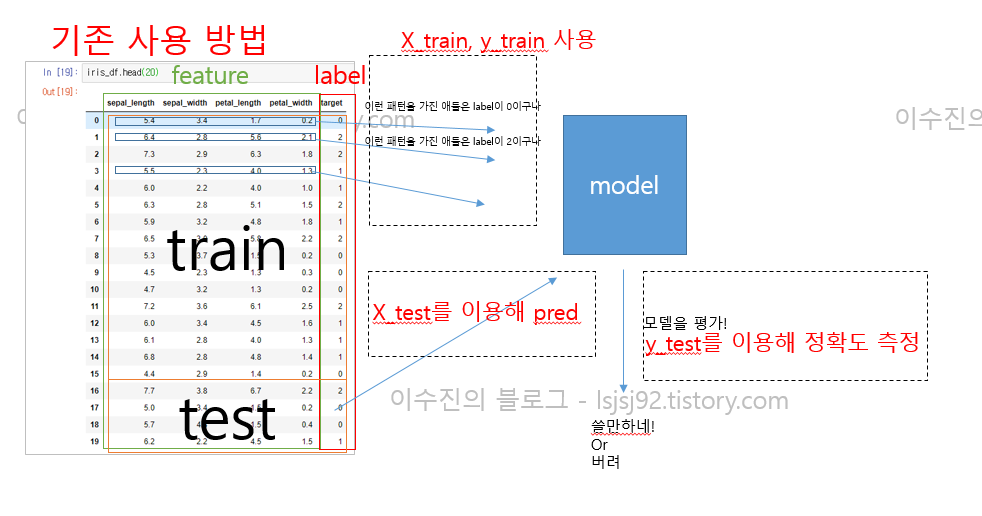


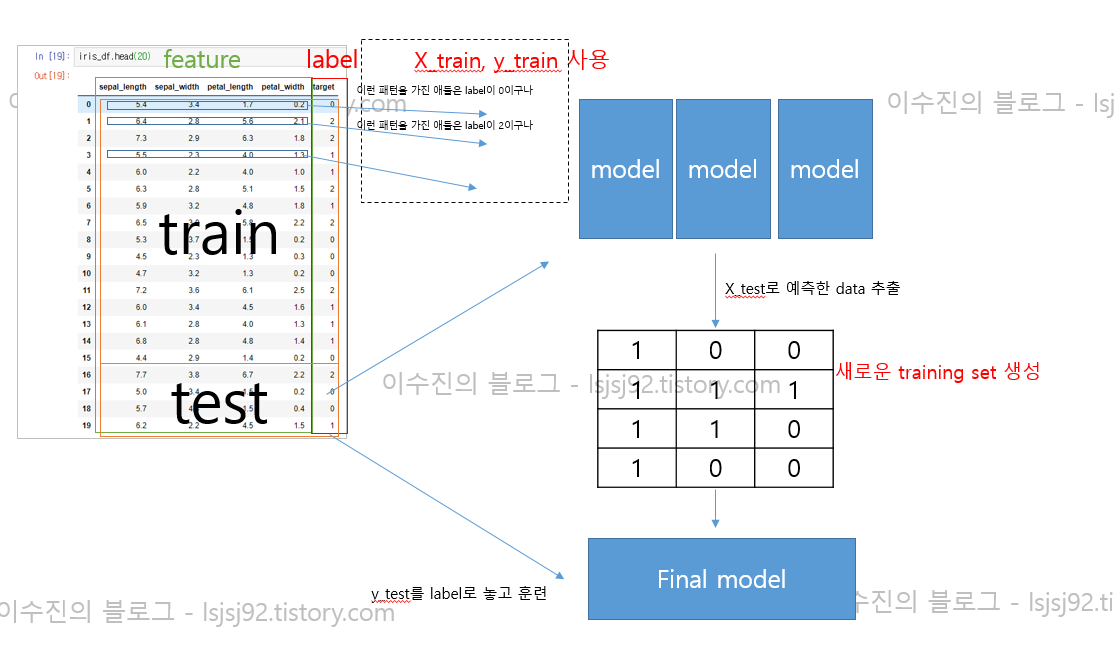

# CV 기반의 stacking

위의 내용은 정~말 기본적인 stacking 내용이었습니다.   

하지만 저렇게 stacking을 하게 되면 동일 데이터로 계속 훈련하게 되니 과적합(overfitting) 문제가 발생하게 됩니다.  
그래서 위와 같은 방법은 기본적인 개념을 설명할 때나 실제로는 쓰이지 잘 쓰이지 않습니다.   

실제로 사용하는 stacking 방법은 CV 기반의 stacking 방법입니다.

CV 기반의 스태킹은 각 모델들이 교차 검증(KFold 등)으로 최종 모델을 위한 학습용 데이터를 생성합니다.
또한, 예측을 위한 테스트용 데이터도 생성하여 이를 기반으로 최종 모델이 학습을 진행하게 됩니다.
순서로 보면 아래와 같습니다.

1. 데이터를 Fold로 나눔
2. 각 모델 별로 Fold로 나누어진 데이터를 기반으로 훈련을 진행(X_train, y_train) 사용
    1. 이때 각 Fold마다 뽑아진 훈련 데이터로 모델을 훈련하고 검증 데이터를 활용해 예측 후 값을 저장
    2. 마찬가지로 각 Fold마다 나온 model을 기반으로 원본 X_test 데이터를 훈련하여 저장 (이것은 추후 Avarage됌)
3. 2까지 진행해서 나온 각 모델별 예측 데이터(2-1)를 모두 stacking하여 최종 모델의 훈련 데이터로 사용
    - label은 원본 y_train 값으로 진행
4. 2-2에서 나온 데이터로 예측을 수행하여 pred 값을 뽑아냄
5. 4에서 나온 pred와 y_test 값을 비교해서 최종 모델 평가


이 말로는 도대체 무슨 소리인지 이해가 잘 안될 것입니다. 그림으로 설명드리죠

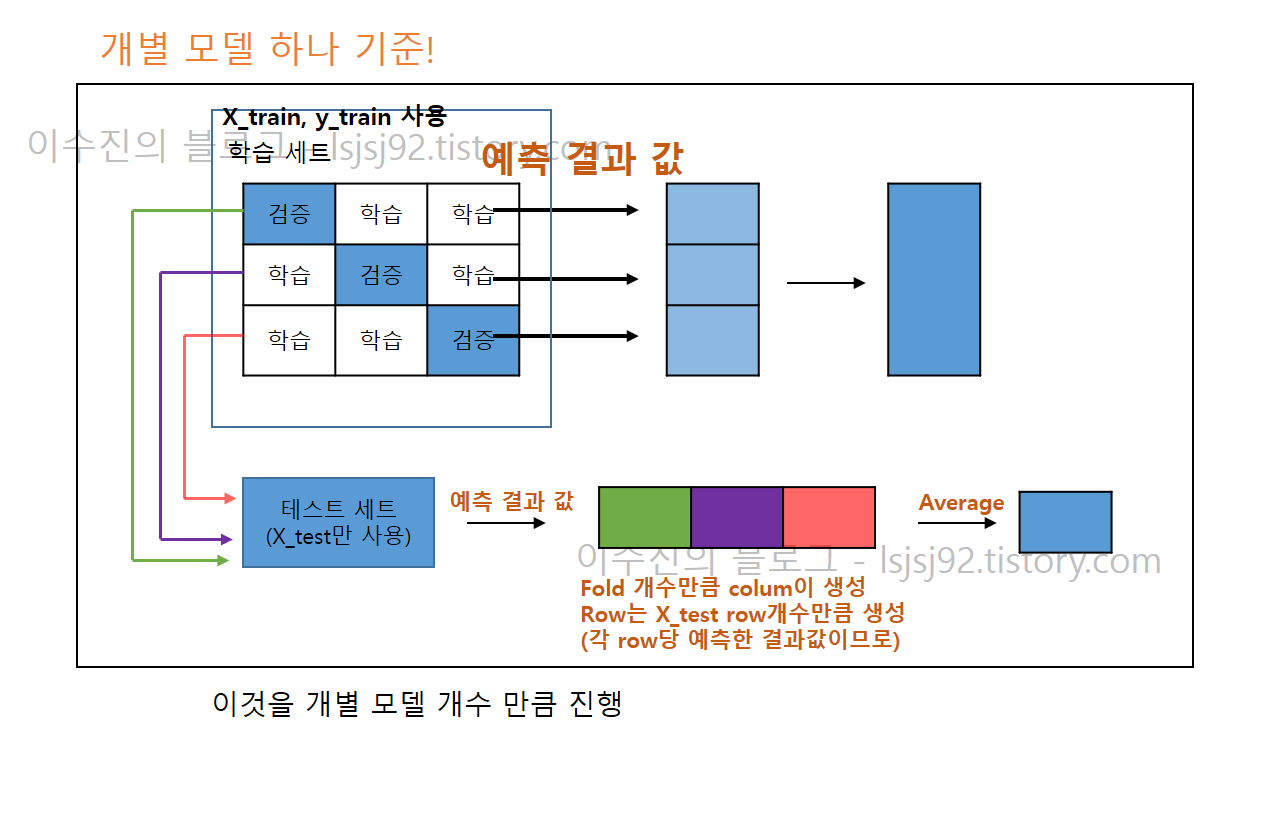

위 그림은 **하나의 모델 기준** 3개의 fold로 진행하는 그림입니다.  
즉, 모델이 3개이면 3개 모델에 대해서 위 그림이 각각 진행되는 것입니다.

1. 각 fold 별로 X_train, y_train을 학습용, 검증용으로 나누고 fold 별 검증 결과 값을 넣어줌
2. 각 fold 별로 1번을 진행하면서 동시에 X_test set에 대해서 예측을 수행해서 예측 결과를 저장
3. fold가 전부 끝나면 1번의 결과로 하나의 모델의 KFold의 내부 수행 결과(예측 값)가 나오게 됌. 이를 모델별로 모아 new_X_train으로 사용
4. 또한, 2의 결과로 나온 X_test set에 대해서 나온 결과를 Average로 한 뒤 합침. 이를 모델별로 모아 new_X_test로 사용 



이제 이 최종 값들을 모아서(stacking) 최종 결과를 도출합니다.  
즉, 아래 그림과 같습니다.

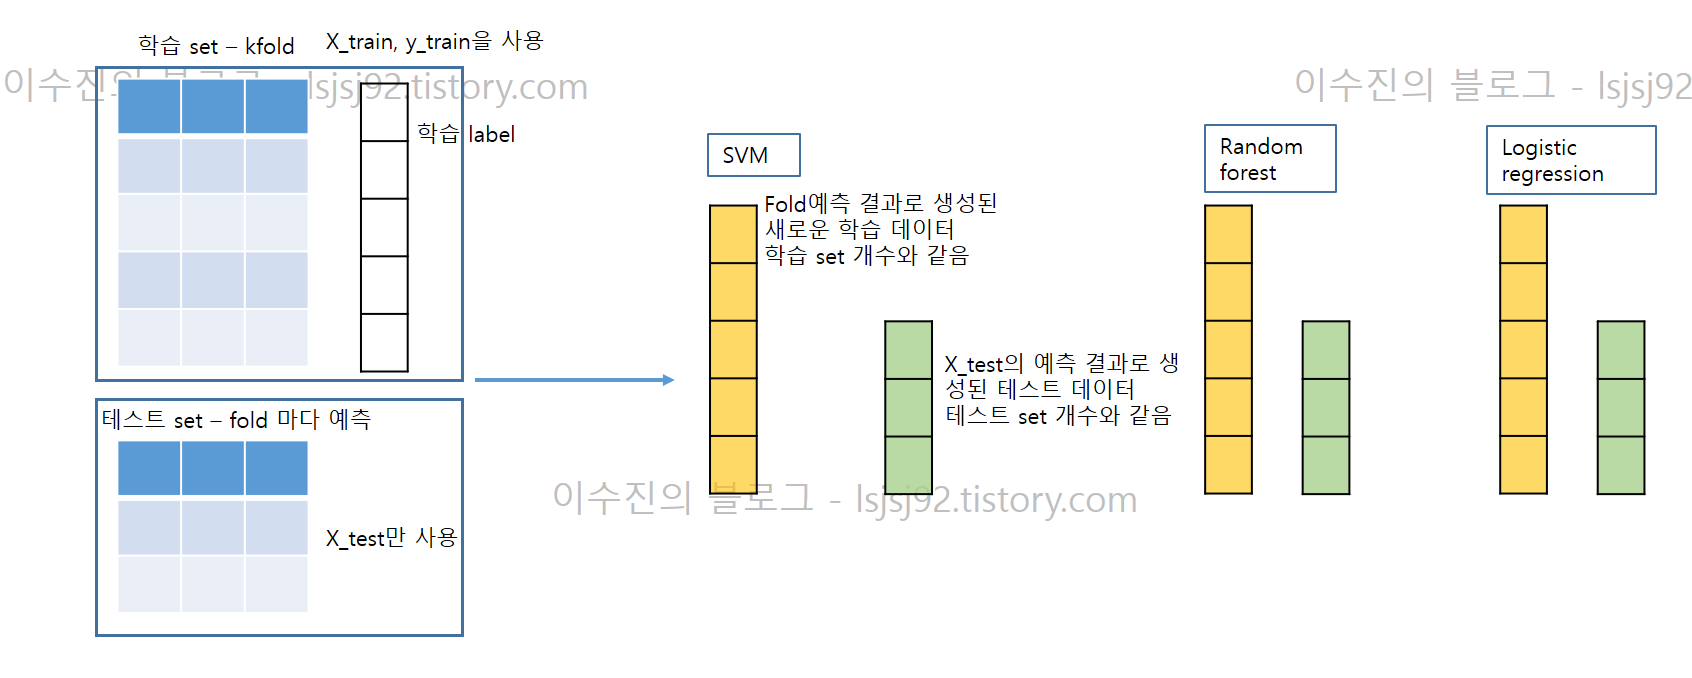

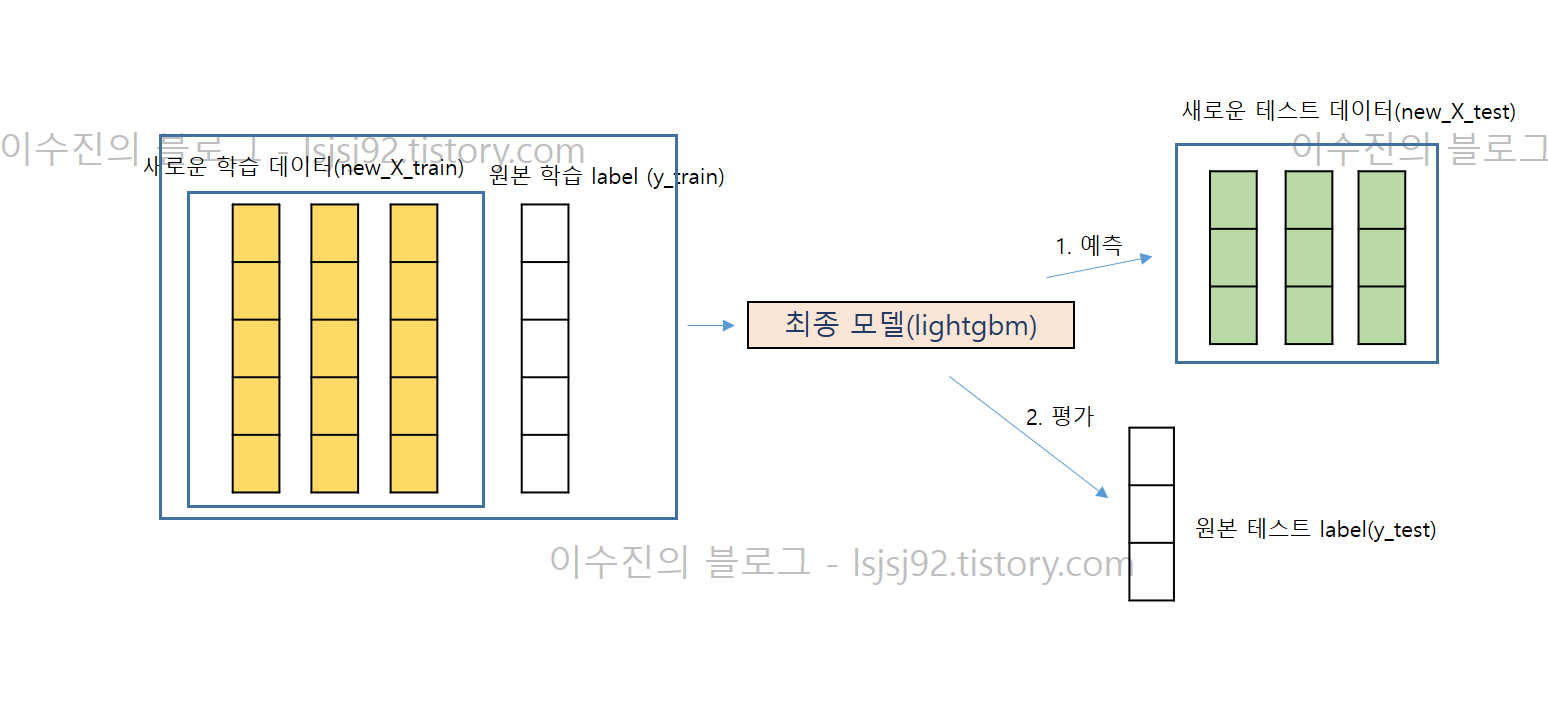

이러한 방식입니다.  

1. 각 모델별 Fold로 수행한 예측 값들을 한 데 모음(stacking) -> 이를 새로운 X train으로 사용
2. 각 모델별 Fold를 수행하면서 Avarage한 X_test 데이터 또한 한 데 모음(stacking) -> 이를 새로운 X_test로 사용
3. 최종 모델을 1번의 데이터와 원본 라벨 y_train를 이용해 훈련 
4. 3번의 결과로 나온 model을 2번의 데이터를 활용해 predict를 하여 예측 값을 뽑아냄
5. 4번의 결과로 나온 값과 원본 y_test를 비교해서 최종 모델 평가



https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

https://www.kaggle.com/getting-started/18153



In [15]:
from sklearn.model_selection import KFold, StratifiedKFold

def get_stacking_data(model, X_train, y_train, X_test, n_folds=5):
    kfold = KFold(n_splits = n_folds, random_state = 0)
    
    # 최종 모델에서 사용할 데이터 셋 셋팅(0 값으로)
    # 만약 shape가 (100, 10) 이었으면 폴드의 검증 과정에서 저장할 데이터는 (100, 1) 모양을 갖게 한다.
    train_fold_predict = np.zeros((X_train.shape[0], 1))
    # test는 X_test 값을 이용해서 매 폴드마다 예측을 하기 때문에 (100, fold개수) 만큼의 shape를 갖게 된다.
    # 그래서 해당 폴드마다 X_test의 예측 값을 해당 fold에 해당되는 열에 넣는다.
    test_predict = np.zeros((X_test.shape[0], n_folds))
    print("model : ", model.__class__.__name__)
    
    for cnt, (train_index, valid_index) in enumerate(kfold.split(X_train)):
        X_train_ = X_train[train_index]
        y_train_ = y_train[train_index]
        X_validation = X_train[valid_index]
        
        #학습
        model.fit(X_train_, y_train_)
        
        #해당 폴드에서 학습된 모델에다가 검증 데이터(X_validation)로 예측 후 저장
        train_fold_predict[valid_index, :] = model.predict(X_validation).reshape(-1, 1)
        
        #해당 폴드에서 생성된 모델에게 원본 테스트 데이터(X_test)를 이용해서 예측을 수행하고 저장
        test_predict[:, cnt] = model.predict(X_test)
    
    #for문이 끝나면 test_pred는 평균을 내서 하나로 합친다.
    test_predict_mean = np.mean(test_predict, axis =1).reshape(-1, 1)
    
    return train_fold_predict, test_predict_mean
    

In [16]:
svm_train, svm_test = get_stacking_data(svm, X_train, y_train, X_test)
rf_train, rf_test = get_stacking_data(rf, X_train, y_train, X_test)
lr_train, lr_test = get_stacking_data(lr, X_train, y_train, X_test)

model :  SVC
model :  RandomForestClassifier
model :  LogisticRegression


이제 새로운 new_X_train과 new_X_test를 생성한다

In [17]:
new_X_train = np.concatenate((svm_train, rf_train, lr_train), axis = 1)
new_X_test = np.concatenate((svm_test, rf_test,lr_test), axis = 1)

In [18]:
print("원본 : ", X_train.shape, X_test.shape)
print("새로운 : ", new_X_train.shape, new_X_test.shape)

원본 :  (455, 30) (114, 30)
새로운 :  (455, 3) (114, 3)


In [19]:
lgbm.fit(new_X_train, y_train)
stack_pred = lgbm.predict(new_X_test)

print("정확도 : {0:.4f}".format(accuracy_score(stack_pred, y_test)))

정확도 : 0.9561


In [22]:
from sklearn.model_selection import KFold, StratifiedKFold

def get_stacking_data2(model, X_train, y_train, X_test, n_folds=5):
    stk = StratifiedKFold(n_splits=n_folds)
    
    # 최종 모델에서 사용할 데이터 셋 셋팅(0 값으로)
    # 만약 shape가 (100, 10) 이었으면 폴드의 검증 과정에서 저장할 데이터는 (100, 1) 모양을 갖게 한다.
    train_fold_predict = np.zeros((X_train.shape[0], 1))
    # test는 X_test 값을 이용해서 매 폴드마다 예측을 하기 때문에 (100, fold개수) 만큼의 shape를 갖게 된다.
    # 그래서 해당 폴드마다 X_test의 예측 값을 해당 fold에 해당되는 열에 넣는다.
    test_predict = np.zeros((X_test.shape[0], n_folds))
    print("model : ", model.__class__.__name__)
    
    for cnt, (train_index, valid_index) in enumerate(stk.split(X_train, y_train)):
        X_train_ = X_train[train_index]
        y_train_ = y_train[train_index]
        X_validation = X_train[valid_index]
        
        #학습
        model.fit(X_train_, y_train_)
        
        #해당 폴드에서 학습된 모델에다가 검증 데이터(X_validation)로 예측 후 저장
        train_fold_predict[valid_index, :] = model.predict(X_validation).reshape(-1, 1)
        
        #해당 폴드에서 생성된 모델에게 원본 테스트 데이터(X_test)를 이용해서 예측을 수행하고 저장
        test_predict[:, cnt] = model.predict(X_test)
    
    #for문이 끝나면 test_pred는 평균을 내서 하나로 합친다.
    test_predict_mean = np.mean(test_predict, axis =1).reshape(-1, 1)
    
    return train_fold_predict, test_predict_mean
    

In [27]:
svm_train2, svm_test2 = get_stacking_data2(svm, X_train, y_train, X_test)
rf_train2, rf_test2 = get_stacking_data2(rf, X_train, y_train, X_test)
lr_train2, lr_test2 = get_stacking_data2(lr, X_train, y_train, X_test)

model :  SVC
model :  RandomForestClassifier
model :  LogisticRegression


In [28]:
new_X_train2 = np.concatenate((svm_train2, rf_train2, lr_train2), axis = 1)
new_X_test2 = np.concatenate((svm_test2, rf_test2,lr_test2), axis = 1)

In [29]:
print("원본 : ", X_train.shape, X_test.shape)
print("새로운 : ", new_X_train2.shape, new_X_test2.shape)

원본 :  (455, 30) (114, 30)
새로운 :  (455, 3) (114, 3)


In [30]:
lgbm.fit(new_X_train2, y_train)
stack_pred = lgbm.predict(new_X_test2)

print("정확도 : {0:.4f}".format(accuracy_score(stack_pred, y_test)))

정확도 : 0.9561
